**RFM анализ**

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

In [2]:
matplotlib.rcParams['figure.figsize'] =  [12.0, 8.0]

In [3]:
to_datetime = lambda d: datetime.strptime(d, '%d.%m.%Y')

Проведем RFM анализ клиентов федерального интернет-магазина детских товаров на основе измененных, но приближенных к реальности данных, которые были предоставлены нв рамках обучения на портале GeekBrains. 

In [ ]:
#Загрузим данные с учетом разделителя и типа данных для дат

In [4]:
df_0 = pd.read_csv('orders_20190822.csv', sep=';', encoding='utf-8', decimal = ',', converters={'o_date': to_datetime})

In [5]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002804 entries, 0 to 2002803
Data columns (total 4 columns):
id_o       int64
user_id    int64
price      float64
o_date     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 61.1 MB


In [6]:
#Посмотрим уникальные значения в каждой колонке
df_0.nunique()

id_o       2002804
user_id    1015119
price        30571
o_date         731
dtype: int64

In [7]:
#Проверим, есть ли незаполненные данные
df_0.isnull().sum()

id_o       0
user_id    0
price      0
o_date     0
dtype: int64

In [8]:
df_0.dtypes

id_o                int64
user_id             int64
price             float64
o_date     datetime64[ns]
dtype: object

In [9]:
#изменим название price на более точное название sales
df_0.columns = ['sales' if x=='price' else x for x in df_0.columns]

In [10]:
df_0.head()

,id_o,user_id,sales,o_date
0,1234491,337544,539.0,2016-01-01
1,1234494,171642,153.3,2016-01-01
2,1234497,260596,55.3,2016-01-01
3,1234498,1105609,752.5,2016-01-01
4,1234500,982696,4410.0,2016-01-01


**Поиск аномалий**

In [ ]:
#Оценим данные с точки зрения аномалии в сумме закупок. 

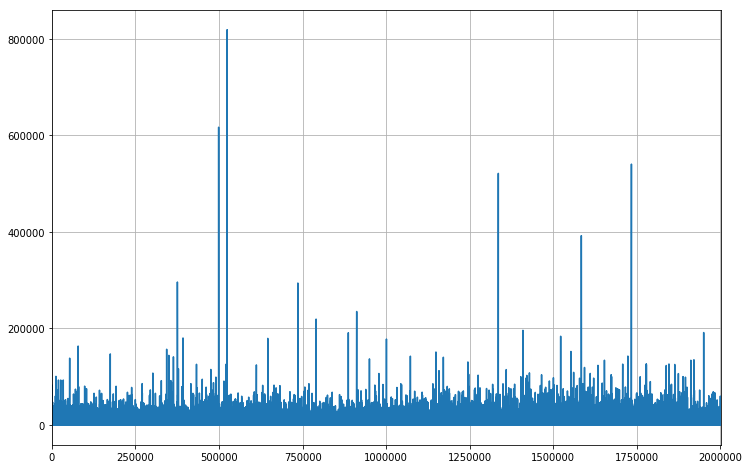

In [11]:
df_0['sales'].plot(grid = True)

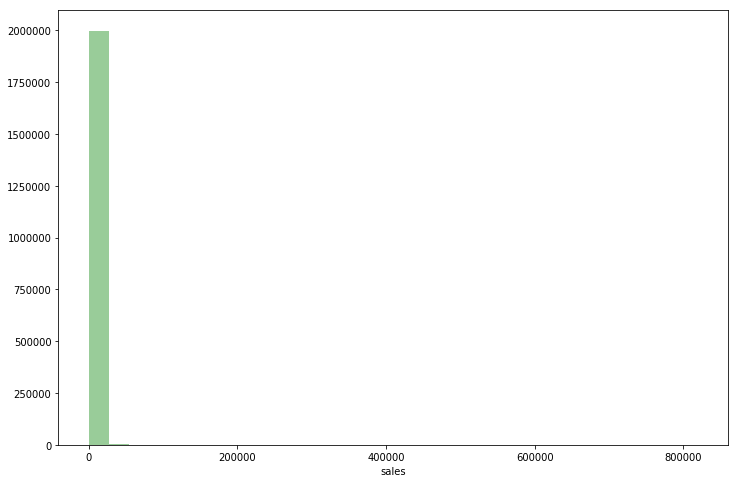

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(df_0.sales, kde=False,color='g',bins=30)

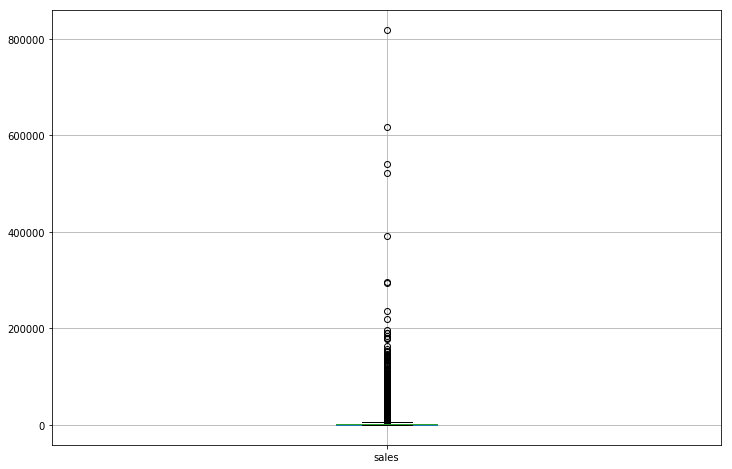

In [13]:
df_0.boxplot(column="sales")

Очевидно, что есть сильные аномалии по сумме закупок свыше 150000 рублей, которые не характерны для всей совокупности. Избавимся от этих выбросов, чтобы они не искажали результаты RFM анализа.

In [14]:
df = df_0.loc[(df_0['sales'] <=150000)]

In [15]:
#Сколько покупок мы потеряли? 
len(df_0) - len(df)

20

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2002784 entries, 0 to 2002803
Data columns (total 4 columns):
id_o       int64
user_id    int64
sales      float64
o_date     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 76.4 MB


Как наши данные меняются по сумме и количеству закупок в течение 2-х лет

In [17]:
#сделаем дату нашим индексом 
df = df.set_index('o_date')

In [18]:
df['year'] = df.index.year

In [19]:
df['month'] = df.index.month

Text(0.5, 1.0, 'Динамика количества покупок в течение 2-х лет')

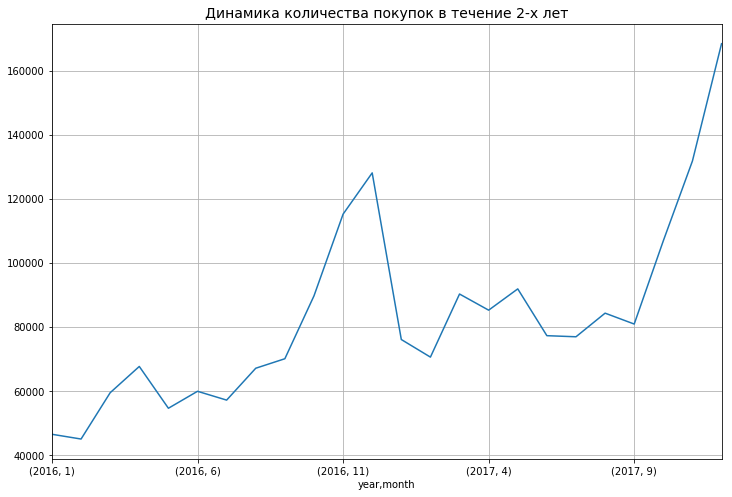

In [20]:
df['sales'].groupby(by=[df.year,df.month]).count().plot(grid = True)
plt.title('Динамика количества покупок в течение 2-х лет', fontsize = 14)

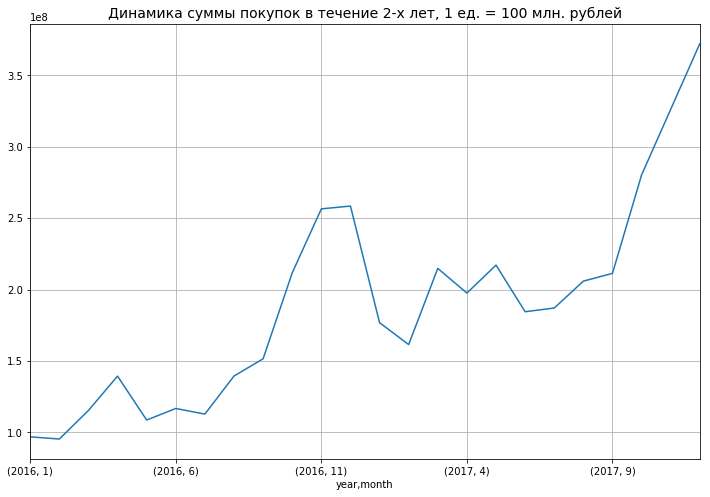

In [21]:
plt.title('Динамика суммы покупок в течение 2-х лет, 1 ед. = 100 млн. рублей', fontsize = 14)
df['sales'].groupby(by=[df.year,df.month]).sum().plot(grid = True)

**RFM анализ**

Проведем анализ клиентской базы на основании лояльности по следующим критериям:

R = Recency, давность последней покупки клиента <br>
F = Frequency, частота (общее количество) покупок клиента <br>
M = Monetary, сумма денег, потраченных клиентом <br>

В нашем случае: 

1) **Recency - давность** <br>

R = 1, если количество дней последней покупки > 60<br>
R = 2, если количество дней последней покупки > 30 и <=60<br>
R = 3, если количество дней последней покупки <= 30<br>

2) **Frequency - частота** <br>

F = 1, если общее количество покупок = 1 <br>
F = 2, если общее количество покупок > 1 и <= 4 <br>
F = 3, если общее количество покупок > 4<br>

2) **Monetary- сумма денег** <br>

F = 1, если общая сумма покупок <=5000 рублей <br>
F = 2, если общая сумма покупок > 5000 и <=15000 рублей <br>
F = 3, если общая сумма покупок > 15000 рублей<br>

***Recency - расчет давности покупок***

In [22]:
rec_dict ={}
latest_date = df.tail(1).index[0] #последняя дата покупки 

for i, v in df.iterrows():
    difference_time = latest_date - i
    user_id = v['user_id']
    
    if difference_time.days <=30:
        rec_dict[user_id] = 1
    if (difference_time.days >30 and difference_time.days <=60 and rec_dict.get(user_id)==None):
        rec_dict[user_id] = 2
    elif (difference_time.days >60 and rec_dict.get(user_id)==None):
        rec_dict[user_id] = 3

***Monetary - расчет суммы денег, потраченных клиентом***

In [23]:
rfm_df = df[['user_id', 'sales']].groupby('user_id').sum().reset_index()

In [24]:
mon_dict = {} #сумма всех покупок по каждому уникальному пользователю 
for i, v in rfm_df.iterrows():
    user_id = v['user_id'] 
    revenue_user = v['sales'] 
    if revenue_user  <= 5000:
        mon_dict[user_id ] = '1'
    elif (revenue_user > 5000 and revenue_user <=15000):
        mon_dict[user_id ] = '2'
    else:
        mon_dict[user_id ] = '3'

***Frequancy - расчет количесто покупок на одного клиента или их частоты***

In [25]:
rfm_df_count = df[['user_id', 'sales']].groupby('user_id').count().reset_index()

In [26]:
freq_dict = {} #количество всех покупок по каждому уникальному пользователю 
for i, v in rfm_df_count.iterrows():
    user_id = v['user_id'] 
    count_user = v['sales'] 
    if count_user ==1:
        freq_dict[user_id ] = '1'
    elif (count_user > 1 and count_user  <=4):
        freq_dict[user_id ] = '2'
    else:
        freq_dict[user_id ] = '3'

In [27]:
#Добавляем колонки monetary, recency, frequency в новый dataframe
rfm_df['recency'] = rfm_df['user_id'].map(rec_dict)
rfm_df['freq'] = rfm_df['user_id'].map(freq_dict)
rfm_df['monetary'] = rfm_df['user_id'].map(mon_dict)

In [28]:
#Соединяем комбинации RFM в отдельный столбец
rfm_df['rfm'] = rfm_df.recency.astype(str) + rfm_df.freq   + rfm_df.monetary 

In [29]:
rfm_df.head()

,user_id,sales,recency,freq,monetary,rfm
0,0,494.2,3,1,1,311
1,1,13844.6,3,2,2,322
2,76,1863.4,3,2,1,321
3,90,6561.8,1,2,2,122
4,91,5413.1,3,2,2,322


Разобъем базу клиентов на 3 группы и посмотрим % товароооборота, которые они сделали за 2 года:
    
Уходящие клиенты <br>
[111, 121, 131, 121, 122, 123, 131, 132, 133]

Спящие клиенты <br>
[211, 212, 213, 221, 222, 223, 231, 232, 233]

Постоянные клиенты <br>
[311, 312, 313, 321, 322, 323, 331, 332, 333]

Оценим объем продаж по сегментам

In [30]:
loosing = ['111', '112', '113', '121', '122', '123', '131', '132', '133']
sleeping = ['211', '212', '213', '221', '222', '223', '231', '232', '233']
regular = ['311', '312', '313', '321', '322', '323', '331', '332', '333']

In [31]:
#Функция расчет объема продаж и количества покупок в сегментах
def sum_count_segment (rfm_segment:list, df): 
    segment_sum = 0
    segment_count = 0
    for i in rfm_segment:
        sum_ = rfm_df['sales'].loc[(rfm_df['rfm'] == i)].sum()
        count_ = rfm_df['sales'].loc[(rfm_df['rfm'] == i)].count()
        segment_sum  += sum_
        segment_count += count_
    return segment_count, segment_sum.round(1)

In [32]:
#Уходящие клиенты
loosing_count, loosing_sum = sum_count_segment (loosing , rfm_df)

In [33]:
#Спящие клиенты
sleeping_count, sleeping_sum = sum_count_segment (sleeping , rfm_df)

In [34]:
#Постоянные клиенты
regular_count, regular_sum = sum_count_segment (regular , rfm_df)

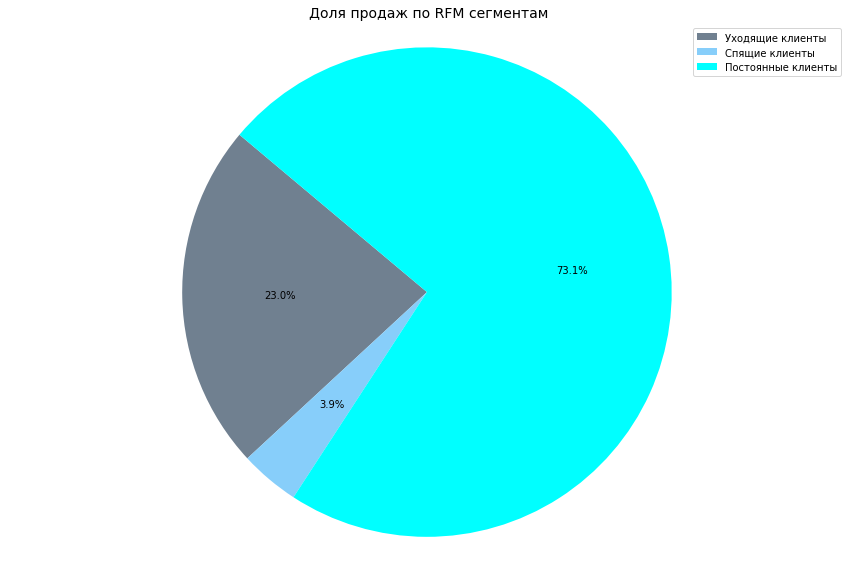

In [35]:
plt.figure(figsize=(12,8))
plt.title('Доля продаж по RFM сегментам', fontsize=14)
labels = ['Уходящие клиенты', 'Спящие клиенты', 'Постоянные клиенты']
sizes = [loosing_sum, sleeping_sum, regular_sum ]
colors = ['slategrey', 'lightskyblue', 'aqua' ]
plt.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

Объем продаж по каждому подсегменту 

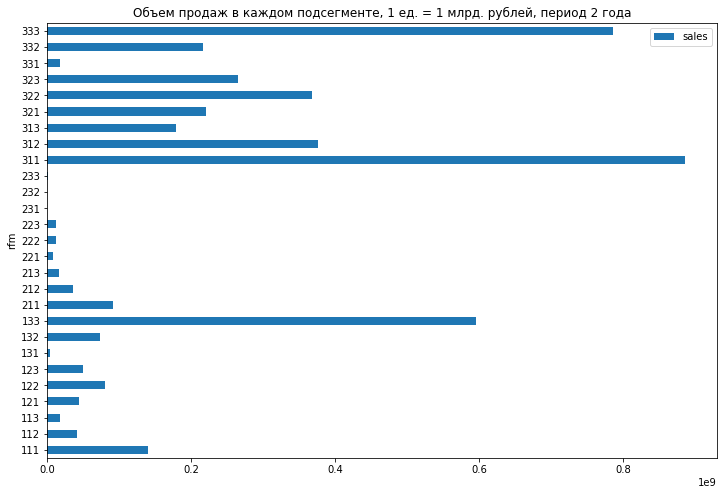

In [36]:
rfm_df[['rfm', 'sales']].groupby('rfm').sum().round(1).\
plot.barh(title='Объем продаж в каждом подсегменте, 1 ед. = 1 млрд. рублей, период 2 года')

In [37]:
#Доля каждого подсегмента в продажах 
rfm_df[['rfm', 'sales']].groupby('rfm').sum().round(0).apply(lambda x: 100 * x / float(x.sum())).style.bar()

,sales
rfm,
111,3.0737
112,0.898592
113,0.375868
121,0.971939
122,1.75428
123,1.08236
131,0.0811315
132,1.61407
133,13.1448


**Резюме**

План действий для развития компаний можно разбить на 3 направления: 

1) лучших клиентов удерживаем <br>
2) середнячков развиваем до лучших <br>
3) уходящих и почти потерянных возвращаем <br>

Например, доля VIP клиентов (333 и 233) составляет 17.6% от суммы продаж. Их можно отправлять особые предложения, предлагать программу лояльности, создавать персональные рекомендации для новых покупок с учетом их предпочтений. Возможно построить для них модель рекомендаций на основе их покупок.

Для новичков с маленьким чеком, их доля составляет 19,5%, должна быть стратегия перехода на более высокий. Возможно стоит проанализировать профиль текущих VIP клиентов и спрогнозировать, кто из текущих новичков наиболее вероятно перейдет в категорию VIP. Исходя из этого уже дальше строить коммуникацию.  

Есть большой потенциал среди уходящего сегмента 133, который составляет 13.14%. Почему клиенты не покупают дальше? Это требует дополнительных исследований, качественных инсайтов и личных интервью. Это связано с тем, что нет ассортимента товаров для их детей? Если да, то какая должна быть стратегия компании для такой аудитории. Возможно стоит подключать партнерскую программу.

В целом текущая база клиентов обладает хорошим потенциалом и большим ядром постоянных клиентов с высоким чеком. Это говорит о высокой лояльности клиентов, востребованности услуг интернет-магазина и сохранении тренда в росте продаж на следующий год. 

***Проверим корректность данных по количеству уникальных пользователей в сегментах и по сумме покупок***

In [41]:
total_count_segment = (loosing_count + regular_count + sleeping_count)
total_unique_df = df['user_id'].nunique()
total_sum_segment = (loosing_sum + regular_sum + sleeping_sum).round(0)
total_sum_df = df['sales'].sum().round(0)

In [39]:
print (f'Количество уникальных пользователей = {total_unique_df}. Количество пользователей всех сегментов = {total_count_segment}')

Количество уникальных пользователей = 1015110. Количество пользователей всех сегментов = 1015110


In [42]:
print (f'Сумма покупок в изначальной базе = {total_sum_df}. Сумма покупок во всех сегментов = {total_sum_segment}')

Сумма покупок в изначальной базе = 4536828767.0. Сумма покупок во всех сегментов = 4536828767.0


Расхождений нет.